# The regression experiment

## is the price correlated to distance to nearest station

## for each meter away from subway station how does the price vary

we start by importing the usual suspects

In [2]:
# import data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import advanced plot drawing library
import seaborn as sns
# import data science library with added geographic functions
import geopandas as gpd
# useful to calculate the Ordinary Least Square linear regression
import statsmodels
# useful to get fast distance calculation,

from sklearn.neighbors import BallTree, KDTree
# useful to access functions like median, mean or std
from scipy import stats
# useful to get map background but hard to install...
# If not available REMOVE this
import contextily as cx
sns.set_style("white")

## 1 – Real Estate dataset: Anjuke

This dataset has been created in UTSEUS in 2017. The souce page for it is (anjuke)[https://shanghai.anjuke.com/sale]

This dataset is given to you as a (pickle)[https://docs.python.org/3/library/pickle.html] which can be used directly as a variable.
The format is called pickle, it is like a zip but can only be read in python. 

In [5]:

real_estate_file = 'utseus-anjuke-real-estate.pk'
anjuke = pd.read_pickle(real_estate_file)

the pickle is just a list of list. The first item is the columns name, the rest is the data
The dataframe need to have the data first, and the name of the columns separately. 
We use (list comprehension)[https://docs.python.org/3/tutorial/introduction.html#lists] to achieve this.

In [6]:
anjuke_df = pd.DataFrame(anjuke[1:],columns=anjuke[0], )

Use .info or .describe functions to get a better idea of the dataset

In [7]:
anjuke_df.info()
anjuke_df.describe()
anjuke_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467029 entries, 0 to 467028
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              467029 non-null  object
 1   address         467029 non-null  object
 2   longitude       467029 non-null  object
 3   latitude        467029 non-null  object
 4   bedroom         467029 non-null  object
 5   room            467029 non-null  object
 6   surface         467029 non-null  object
 7   price           467029 non-null  object
 8   onesquaremeter  467029 non-null  object
 9   tags            467029 non-null  object
 10  district        467029 non-null  object
 11  neighborhood    467029 non-null  object
 12  done            467029 non-null  object
dtypes: object(13)
memory usage: 46.3+ MB


,id,address,longitude,latitude,bedroom,room,surface,price,onesquaremeter,tags,district,neighborhood,done
0,A888553302,宝山-大场 金地艺境(宝山)(555弄),121.34392735101,31.3193561718426,2,2,30.0,1160000.0,38666.6666666667,金地开发 **首推 地铁首通 价格首降 配套就是你能想到的,baoshan,dachang,1
1,A888376847,宝山-大场 骏华苑,121.407324884273,31.3023675431043,1,1,38.0,1950000.0,51315.7894736842,龙璟公馆嘉兴市近万达广场，北大附属实验校区，地铁沿线高铁站旁,baoshan,dachang,1
2,A885088482,宝山-大场 琉樽尚品(255弄),121.397487377268,31.2908711986862,3,2,92.0,5350000.0,58152.1739130435,92+7平书房，婚房装修30万！满2年税少11万！再降20万,baoshan,dachang,1
3,A885392981,宝山-大场 琉樽尚品（255弄）,121.397487377268,31.2908711986862,2,2,68.0,4350000.0,63970.5882352941,中环景观，电梯复式，豪装45万全送，拎包入住，小格局大设计，,baoshan,dachang,1
4,A885831305,宝山-大场 美好家小区,121.421397234518,31.302658471085,2,2,80.0,4000000.0,50000.0,美好家南北通精装2房板式房型采光好随时好看带天井,baoshan,dachang,1


all of the field we see in the columns are object and have not been correctly imported as numbers. Consequently we cannot calculate with these columns as they are considered as words. We need numbers. To convert from words to numbers we use a special function from python. 

All numeric columns shall transformed into floats using pandas (to_numeric)[https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html] function.

In [8]:
numeric_columns = ['longitude', 'latitude', 'bedroom', 'room', 'surface', 'price', 'onesquaremeter']

# put the function in the following line
anjuke_df[numeric_columns] = anjuke_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

now we can have some numbers that could not be converted. the rows containing these undefined values need to be dropped. 

Do that using the function (dropna)[https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html]

In [9]:
anjuke_df = anjuke_df.dropna()

check if the colums have been successfully changed.

You should observe that we 'lost' 3962 records that were incomplete with a non numeric data

use .info() again

In [10]:
anjuke_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 463067 entries, 0 to 467028
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              463067 non-null  object 
 1   address         463067 non-null  object 
 2   longitude       463067 non-null  float64
 3   latitude        463067 non-null  float64
 4   bedroom         463067 non-null  int64  
 5   room            463067 non-null  int64  
 6   surface         463067 non-null  float64
 7   price           463067 non-null  float64
 8   onesquaremeter  463067 non-null  float64
 9   tags            463067 non-null  object 
 10  district        463067 non-null  object 
 11  neighborhood    463067 non-null  object 
 12  done            463067 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 49.5+ MB


Time to tranform the dataset into a geodataframe now so we can perform geographic operations

Right now we just have GPS has numbers in columns. This is not ready to be used on a map. For that we need to convert it into a geographic object that can be a point, a line or a polygon. In our case it is a point 

In [11]:
anjuke_gdf = gpd.GeoDataFrame(
        anjuke_df, 
        geometry=gpd.points_from_xy(anjuke_df.longitude, anjuke_df.latitude), crs=4326)

plot the data on a map using the plot function with the following properties
plot(markersize=0.5, color='black', figsize=(10,10))

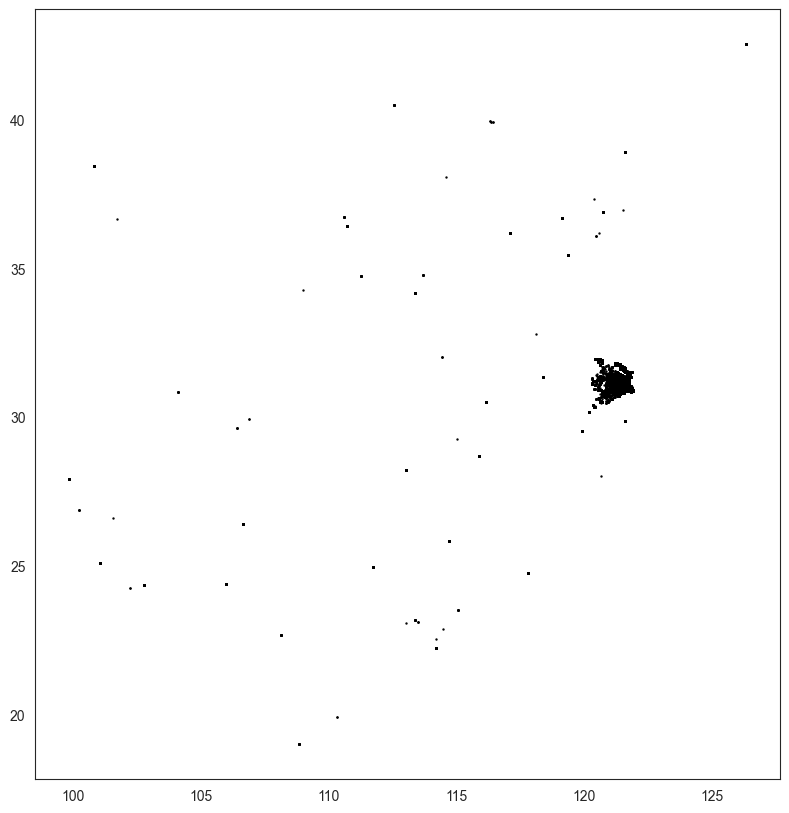

In [12]:
import matplotlib.pyplot as plt
anjuke_gdf.plot(markersize=0.5, color='black', figsize=(10, 10))
plt.show()

We observe that data are not only in Shanghai. 

Write HERE why you think it is like this ?

Sûrement à cause d'erreurs dans les données. On possédait un jeu de données assez conséquent, certains ont pus être mal saisies.






To have an idea of the spread of data, we can print or we can check the boundaries using the property (total_bounds)[https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html]

In [13]:
# use the property and print the result

anjuke_gdf.total_bounds

array([ 99.82410591,  18.99369628, 126.33039253,  42.54940926])

In both cases, it seems there are data outside Shanghai.

To limit it we have two options:
- one is to use _cx_ to specify a bounding box
- another one is to provide a shape for the area and filter points within

### Lets start with bounding box

to find the bounding box you can use GIS or search for it. we can use [bboxfinder.com](http://bboxfinder.com/)  for example

In [14]:
print(f'before {len(anjuke_gdf)}')
west = 120.85
east = 121.99
north = 31.89
south = 30.60

xmin, ymin, xmax, ymax = (west,south,east,north)
anjuke_filterbb_gdf = anjuke_gdf.cx[xmin:xmax, ymin:ymax]
print(f'after {len(anjuke_filterbb_gdf)}')

before 463067
after 454134


we check if the latitude or longitude we have is in GCJ format of GPS format by looking at the huangpu river

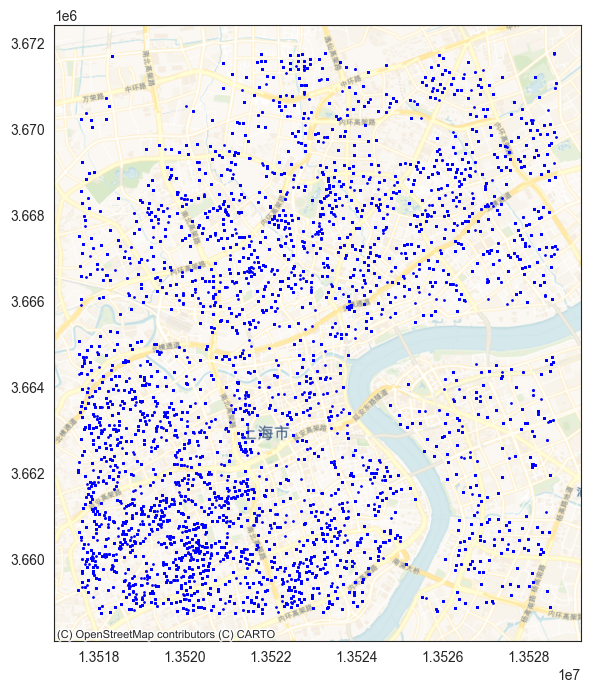

In [15]:
ax = anjuke_filterbb_gdf.cx[121.43:121.53, 31.20:31.30].to_crs(3857).plot(markersize=1, color='b', figsize=(8,8))

# use plot with ax here if you dont have cx
ax.plot(markersize=1, color='b', figsize=(8,8))
# use cx here if you have it
cx.add_basemap(ax,source=cx.providers.CartoDB.Voyager)

## 2 – POI dataset: Gaode

This dataset has been bought from Gaode for SHU Cendus institute in 2020. We choose the POI from 2017 to be consistant with the anjuke dataset also from 2017 

In [16]:
poi_df = pd.read_csv('shanghaiPOI2017.csv',delimiter=';', decimal=',', low_memory=False)

In [17]:
poi_df.columns

Index(['Unnamed: 0', 'ID', 'POIID', 'GCJX', 'GCJY', 'NAME', 'ADD', 'TEL',
       'TYPE', 'AREAID', 'IDKEY', 'GPSX', 'GPSY', 'TYPE1', 'TYPE2', 'TYPE3',
       'TYPE4', 'TYPE5', 'TYPE3.1', 'TYPE3.2', 'TYPE3.3', 'TYPE1.N', 'TYPE2.N',
       'TYPE3.N', 'TYPE3.1.N', 'TYPECODE', 'GBCODE'],
      dtype='object')

find the GBCode to all of them

In [18]:
# write the function to create the geodataframe here usin gthe same method as␣before
poi_gdf = gpd.GeoDataFrame(
    poi_df,

    geometry=gpd.points_from_xy(poi_df.GPSX, poi_df.GPSY), crs=4326)

In [19]:
poi_gdf.to_crs(4576, inplace=True)
anjuke_filterbb_gdf.to_crs(4576, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [20]:
gbcodes = poi_gdf.GBCODE.unique()
len(gbcodes)

323

it looks like the subway stations have a GBCode of XXXX.

The complete description of China BGCode used to categorize POI information can be found [GB/T 35648-2017 ](https://openstd.samr.gov.cn/bzgk/gb/newGbInfo?hcno=3330BB5A1FF81A61F8A7432B0BB4AE01)

In [21]:
def what(gbcode):
    return poi_gdf.loc[poi_gdf.GBCODE == gbcode,['TYPE']].head(1)
what(200402)


,TYPE
69644,交通设施服务;地铁站;出入口


In [22]:
anjuke_filterbb_gdf = anjuke_filterbb_gdf[
    (anjuke_filterbb_gdf.onesquaremeter < 3*anjuke_filterbb_gdf.
onesquaremeter.std() )&
    (anjuke_filterbb_gdf.onesquaremeter > -3*anjuke_filterbb_gdf.
onesquaremeter.std())].copy()

In [23]:
anjuke_filterbb_gdf.geometry.head()

0    POINT (21342354.732 3467628.095)
1    POINT (21348363.197 3465655.143)
2     POINT (21347407.938 3464393.81)
3     POINT (21347407.938 3464393.81)
4    POINT (21349703.629 3465668.134)
Name: geometry, dtype: geometry

In [24]:
final_gbcodes = []
coords2 = np.array([[geom.x, geom.y] for geom in anjuke_filterbb_gdf.geometry])
for gbcode in gbcodes:
    if np.isnan(gbcode):
        continue
    if len(poi_gdf[poi_gdf.GBCODE == gbcode]) < 1:
        continue
    final_gbcodes.append(str(gbcode))

    str(gbcode)
    coords1 = np.array([[geom.x, geom.y] for geom in poi_gdf[poi_gdf.GBCODE ==gbcode].geometry])
    kdtree = KDTree(coords1)
    anjuke_filterbb_gdf[str(gbcode)], _ = kdtree.query(coords2, k=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fr

In [25]:
for i,t in enumerate(anjuke_filterbb_gdf.columns.to_list()):
    print(i,t)

0 id
1 address
2 longitude
3 latitude
4 bedroom
5 room
6 surface
7 price
8 onesquaremeter
9 tags
10 district
11 neighborhood
12 done
13 geometry
14 990000.0
15 209900.0
16 201203.0
17 201200.0
18 201202.0
19 201204.0
20 200301.0
21 190600.0
22 130900.0
23 110100.0
24 110503.0
25 201201.0
26 200501.0
27 200504.0
28 200402.0
29 200401.0
30 200100.0
31 200104.0
32 200102.0
33 200601.0
34 201401.0
35 230100.0
36 170000.0
37 200201.0
38 210501.0
39 219900.0
40 201402.0
41 129900.0
42 160303.0
43 160300.0
44 220100.0
45 220301.0
46 160600.0
47 110500.0
48 120100.0
49 120300.0
50 120400.0
51 120200.0
52 160200.0
53 160112.0
54 160121.0
55 220101.0
56 210800.0
57 210900.0
58 150404.0
59 179900.0
60 119900.0
61 130202.0
62 139900.0
63 190900.0
64 201400.0
65 190000.0
66 240105.0
67 240109.0
68 240300.0
69 240113.0
70 240203.0
71 240202.0
72 190603.0
73 190100.0
74 190401.0
75 190104.0
76 190406.0
77 190203.0
78 190202.0
79 190403.0
80 190404.0
81 190407.0
82 190106.0
83 190701.0
84 190501.0
85 

In [40]:
'''
on fait ça pour vérifier si les distances sont correctes.
Avant, il prenait en compte que la latitude et la longitude,
alors que ça dépend également du type d'endroit, du prix, etc.
'''


"\non fait ça pour vérifier si les distances sont correctes.\nAvant, il prenait en compte que la latitude et la longitude,\nalors que ça dépend également du type d'endroit, du prix, etc.\n"

In [37]:
what(990000.0) #activitées évenementielles

,TYPE
0,事件活动;事件活动;事件活动


In [29]:
# On sélectionne uniquement les colonnes correspondant aux distances aux POI
poi_columns = [col for col in anjuke_filterbb_gdf.columns if col.isdigit()]

# On extrait uniquement ces colonnes
poi_data = anjuke_filterbb_gdf[poi_columns]

# On vérifie que toutes les colonnes contiennent bien des valeurs valides
poi_data = poi_data.dropna(axis=1)


À ce stade, nous avons calculé la distance entre chaque appartement et chaque type de Point of Interest (POI), identifié par un code unique appelé GBCODE. Cependant, tous les POI ne sont pas représentés de manière significative dans la base de données. Nous filtrons donc les colonnes associées aux POI afin de ne conserver que celles contenant des données valides pour effectuer notre analyse.

In [34]:
print(poi_data.shape)
print(poi_data.head())

print(anjuke_filterbb_gdf.columns.tolist()[:20])  # ou [:50]

# On sélectionne les colonnes dont le nom est un nombre float (sous forme de string)
poi_columns = [col for col in anjuke_filterbb_gdf.columns
               if isinstance(col, str) and col.replace('.', '', 1).isdigit()]

# On extrait les colonnes et supprime celles qui contiennent trop de valeurs manquantes
poi_data = anjuke_filterbb_gdf[poi_columns].dropna(axis=1, thresh=int(0.95 * len(anjuke_filterbb_gdf)))


(449599, 0)
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
['id', 'address', 'longitude', 'latitude', 'bedroom', 'room', 'surface', 'price', 'onesquaremeter', 'tags', 'district', 'neighborhood', 'done', 'geometry', '990000.0', '209900.0', '201203.0', '201200.0', '201202.0', '201204.0']


In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardisation des données (obligatoire avant PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(poi_data)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


La PCA (analyse en composantes principales) est une technique de réduction de dimensionnalité. Elle permet d’identifier les directions (composantes principales) qui capturent le plus de variance dans les données. Avant de l’appliquer, nous standardisons les distances pour que toutes les colonnes aient la même échelle, car une distance exprimée en mètres aurait plus de poids qu'une autre simplement à cause de son unité.

📊 3. Visualiser la variance expliquée par les composantes

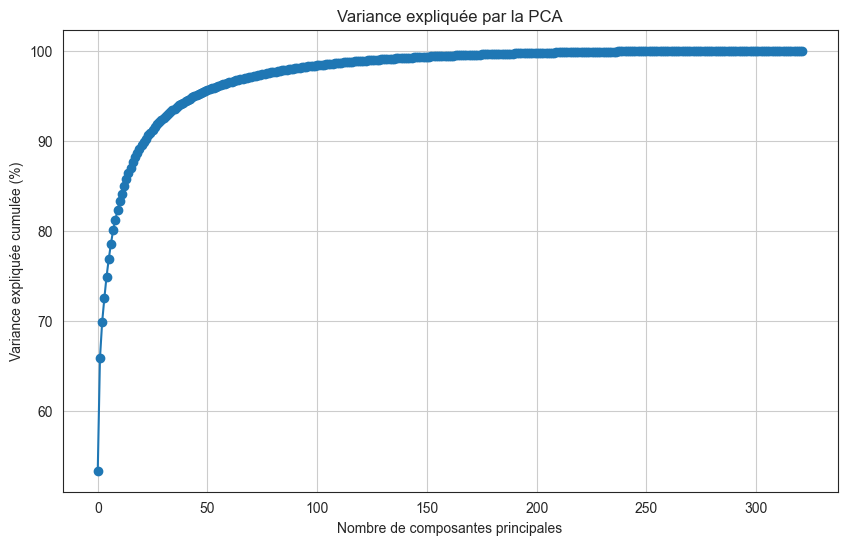

In [36]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée (%)')
plt.title('Variance expliquée par la PCA')
plt.grid(True)
plt.show()


Le graphique ci-dessous montre la proportion de variance expliquée par les différentes composantes principales. Cela nous permet de déterminer combien de dimensions sont réellement nécessaires pour représenter efficacement nos données. Dans notre cas, les deux premières composantes capturent environ X % de la variance totale (à ajuster selon ton graphique).

🌟 4. Afficher les POI les plus influents (Top 10 dans PC1)

In [37]:
# Récupérer les poids de chaque feature dans PC1
loading_scores = pd.Series(pca.components_[0], index=poi_data.columns)
sorted_loading = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading.head(10).index
print("Top 10 POI les plus influents dans la première composante :")
print(top_10_features)


Top 10 POI les plus influents dans la première composante :
Index(['210202.0', '130802.0', '130703.0', '130800.0', '210201.0', '130500.0',
       '150700.0', '189900.0', '110503.0', '150405.0'],
      dtype='object')


Chaque composante principale est une combinaison linéaire de l’ensemble des POI. En analysant les poids (ou loadings) des features dans la première composante, nous identifions les POI qui expliquent le plus la variance. Voici les 10 POI les plus influents dans PC1, c’est-à-dire ceux dont la présence ou l’absence à proximité influence le plus la classification des logements dans notre analyse.

🎨 5. Visualiser les logements projetés sur PC1 et PC2

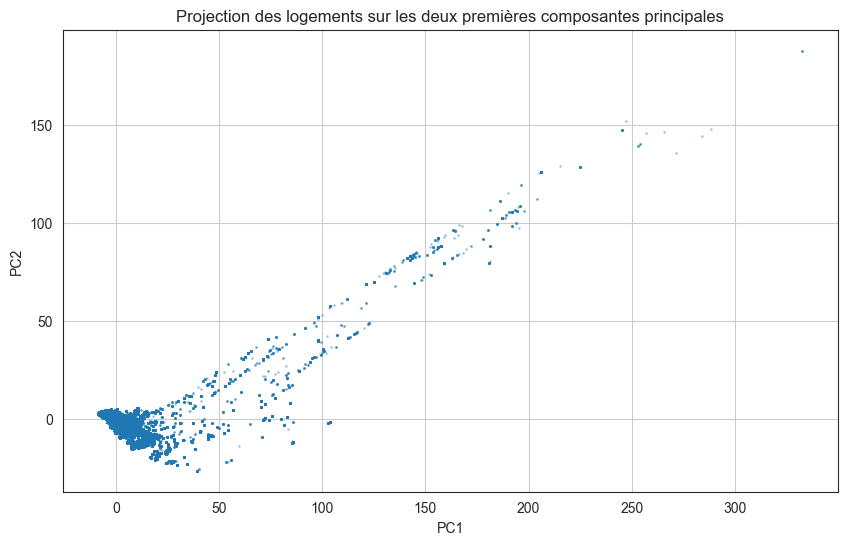

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1, alpha=0.3)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection des logements sur les deux premières composantes principales')
plt.grid(True)
plt.show()


Nous projetons chaque appartement sur les deux premières composantes principales (PC1 et PC2). Cette visualisation 2D permet de détecter des regroupements naturels, voire des tendances spatiales dans les données. Les points proches dans ce graphique ont des profils similaires en termes de distances aux différents POI.